In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from functools import reduce

In [31]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.layers import SimpleRNN, RNN, LSTM, Embedding
from keras.optimizers import Adam, SGD

# Utility Functions

In [3]:
def load_pkl(path):
    return pickle.load(open(path, "rb"))

In [4]:
def load_data(data):
    keys = ['message_seqs', 'encoded_seqs', 'noisy_seqs', 'viterbi_decoded_seqs']
    x = data[keys[2]] # noisy sequences will be our input to our models
    y = data[keys[0]]
    y_viterbi_decoded = data[keys[3]]
    
    x = np.array(x)
    y = np.array(y)
    y_viterbi_decoded = np.array(y_viterbi_decoded)
    
    return x, y, y_viterbi_decoded

In [5]:
def load(path):
    return load_data(load_pkl(path))

In [6]:
def load_pkl_paths_from_folder(dir_path, recursive=False):
    if recursive:
        return np.sort(list(filter(lambda x: ".pkl" in x,
                            [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(dir_path)) 
                                                 for f in fn])))
    else:
        return np.sort([dir_path + "/" + x for x in os.listdir(dir_path) if ".pkl" in x ])

In [7]:
def get_param_from_filename(filename, param):
    split_token = "_"
    if param == "k":
        split_token = "_k"
    elif param == "p":
        split_token = "_p"
    elif param == "r":
        split_token = "_r"
    elif param == "l":
        split_token = "_l"
    elif param == "e":
        split_token = "_e"
    elif param == "n":
        split_token = "_n"
    else:
        raise ValueError("unrecognized parameter", param)
        
    res = filename.split("/")[-1].split(split_token)[1].split("_")[0]
    if ".pkl" in res:
        res = res.split(".pkl")[0]
    
    return float(res)

# Data Processing

In [8]:
def train_test_split(x, y, test_ratio=0.2):
    indicies = np.arange(len(x))
    np.random.shuffle(indicies)
    
    split_inx = int(len(x) * (1-test_ratio))
    X_train, X_test = x[indicies[:split_inx]], x[indicies[split_inx:]]
    y_train, y_test = y[indicies[:split_inx]], y[indicies[split_inx:]]
    
    return X_train, X_test, y_train, y_test

In [9]:
def group_sort(benchmark, *args):
    sorted_indicies = np.argsort(benchmark) 
    
    benchmark = np.array(benchmark)
    args = list(map(lambda x: np.array(x), args))
    
    benchmark_sorted = benchmark[sorted_indicies]
    args_sorted = list(map(lambda x: x[sorted_indicies], args))
    
    return benchmark_sorted, args_sorted

In [10]:
def one_hot(data):
    res = []
    for d in data:
        res.append([0,0])
        res[-1][int(d)] = 1
    return np.array(res)

def one_hot_datasets(y):
    return np.array(list(map(lambda x: one_hot(x), y)))

def onehot_to_normal(dataset):
    return np.argmax(dataset, axis=2)

In [11]:
variable_desc = {
    "k": "message length (K-bit)",
    "p": "prob P of Bernoulli distribution",
    "e": "corruption probability E",
    "l": "constraint length L"
}

In [12]:
def build_data_from_path(path, test_ratio=0.2, X_reshape=None):
    X, y, y_viterbi_decoded = load(path)
    y_oh = one_hot_datasets(y)
    
    if X_reshape:
        X = X.reshape(X_reshape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_ratio=test_ratio)
    
    return (X_train, y_train), (X_test, y_test), (X, y, y_oh, y_viterbi_decoded)

In [28]:
def build_data_from_path(path, test_ratio=0.2, X_reshape=None):
    X, y, y_viterbi_decoded = load(path)
    y_oh = one_hot_datasets(y)
    
    if X_reshape:
        total_shape = np.product(X_reshape[1:])
        if total_shape != X.shape[1]:
            X = X[:,:total_shape]
        X = X.reshape(X_reshape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_ratio=test_ratio)
    
    return (X_train, y_train), (X_test, y_test), (X, y, y_oh, y_viterbi_decoded)

# Model Definitions

Optimizers

In [14]:
optimizers = {
    "adam": Adam, 
    "sgd":  SGD
}

Fully Connected Neural Net

In [15]:
default_fnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.01,
    "learing_rate": 0.015,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [16]:
default_fnn_architecture = [32,64,100]

Convolution 1D Nerual Net

In [17]:
default_cnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "dropout_keep_prob": 0.5,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "conv_padding": "same",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

Avaliable Layers:

Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D

In [18]:
default_cnn_architecture = [
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("flatten"),
    ("dense", 200),
    ("dropout")
]

# Model Construction

In [19]:
def build_fnn(input_shape, 
              output_shape, 
              architecture=default_fnn_architecture, 
              param=default_fnn_param):
    """
    Train a FNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, output_units in enumerate(architecture):
        if i == 0:
            model.add(Dense(output_units, activation=param["activation"],
                        input_shape=input_shape,
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
        else:
            model.add(Dense(output_units, activation=param["activation"],
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [20]:
def train_fnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

In [21]:
def build_cnn(input_shape, 
              output_shape, 
              architecture=default_cnn_architecture, 
              param=default_cnn_param):
    """
    Train a CNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, layer in enumerate(architecture):
        if layer[0] == "conv1d":
            model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
        elif layer[0] == "flatten":
            model.add(Flatten())
        elif layer[0] == "dense":
            model.add(Dense(layer[1], activation=param["activation"]))
        elif layer[0] == "dropout":
            model.add(Dropout(param["dropout_keep_prob"]))
        else:
            raise ValueError("do not recognize layer", layer[0])
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [22]:
def train_cnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

# Evaluation Metrics

In [23]:
def accuracy(y, y_pred, argmax=False, viterbi=False):
    y_pred_binary = y_pred
    
    if viterbi:
        y_pred_binary = [p[:y.shape[1]] for p in y_pred]
    elif argmax:
        y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
        assert y.shape == y_pred_binary.shape, "prediction and ground truth must \
        have same shape\nExpected:{0} Actual:{1}".format(y.shape, y_pred_binary.shape)
    
    return np.sum(y == y_pred_binary) / np.product(y.shape)

In [24]:
def model_accuracy(model, x, y, argmax=False):
    if argmax:
        y_pred = model.predict(x)
        return accuracy(y, y_pred, argmax)
    else:
        return model.evaluate(x, y, verbose=0)[1]

In [25]:
def pred_vs_truth(model, x, y, n_show=2, y_truth_is_onehot=False):
    indicies = np.random.randint(low=0, high=x.shape[0], size=n_show)
    y_pred = model.predict(x[indicies])
    y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
    
    truth = y[indicies].astype(y_pred_binary.dtype)
    
    if y_truth_is_onehot:
        truth = onehot_to_normal(truth)
    
    for i in range(len(truth)):
        print("\n############## Example {0} ##############".format(i))
        print("Expected:\n", truth[i])
        print("Actual:\n", y_pred_binary[i])

# Graph

In [26]:
def plot_acc(title, acc):
    epoch = np.arange(1,len(acc)+1,1)
    
    plt.figure(figsize=(20,6))

    plt.subplot(121)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel("accuracy")
    plt.plot(epoch, acc, "green")

    plt.subplot(122)
    plt.title("Log Log {0}".format(title))
    plt.xlabel('epoch')
    plt.ylabel("accuracy")
    plt.plot(epoch, np.log(-np.log(acc)), "red")

# Experiments

In [43]:
experiment_results = dict()

k: 10, e: 0.05

In [29]:
train, test, original = build_data_from_path("../data/dataset_n25000_k10_e0.05.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [32]:
lr = 0.005
model = Sequential()

model.add(Embedding(2, 10))
model.add(Dropout(0.5))

model.add(LSTM(200, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=50, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
 - 4s - loss: 0.6600 - acc: 0.5491 - val_loss: 0.5985 - val_acc: 0.6018
Epoch 2/50
 - 2s - loss: 0.5947 - acc: 0.6172 - val_loss: 0.5452 - val_acc: 0.6679
Epoch 3/50
 - 2s - loss: 0.5367 - acc: 0.6763 - val_loss: 0.4839 - val_acc: 0.7157
Epoch 4/50
 - 2s - loss: 0.4905 - acc: 0.7163 - val_loss: 0.4208 - val_acc: 0.7716
Epoch 5/50
 - 2s - loss: 0.4383 - acc: 0.7619 - val_loss: 0.3620 - val_acc: 0.8205
Epoch 6/50
 - 2s - loss: 0.3921 - acc: 0.7959 - val_loss: 0.3120 - val_acc: 0.8424
Epoch 7/50
 - 2s - loss: 0.3452 - acc: 0.8286 - val_loss: 0.2644 - val_acc: 0.8794
Epoch 8/50
 - 2s - loss: 0.3049 - acc: 0.8542 - val_loss: 0.2162 - val_acc: 0.9078
Epoch 9/50
 - 2s - loss: 0.2616 - acc: 0.8795 - val_loss: 0.1882 - val_acc: 0.9187
Epoch 10/50
 - 2s - loss: 0.2333 - acc: 0.8972 - val_loss: 0.1498 - val_acc: 0.9423
Epoch 11/50
 - 2s - loss: 0.1988 - acc: 0.9173 - val_loss: 0.1213 - val_acc: 0.9574
Epoch 12/50
 - 2s - loss: 0.1692 - a

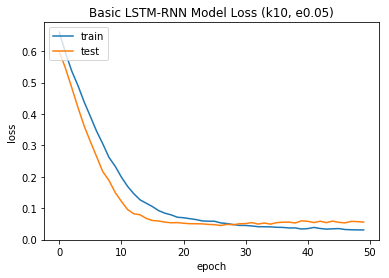

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

Test Accuracy is 0.983069994354248

############## Example 0 ##############
Expected:
 [0 1 1 1 1 0 1 1 1 0]
Actual:
 [0 1 1 1 1 0 1 1 1 0]

############## Example 1 ##############
Expected:
 [0 0 0 0 0 0 1 1 0 0]
Actual:
 [0 0 0 0 0 0 1 1 0 0]

############## Example 2 ##############
Expected:
 [0 0 0 1 1 1 0 0 1 1]
Actual:
 [0 0 0 1 1 1 0 0 1 1]

############## Example 3 ##############
Expected:
 [1 0 1 1 1 0 1 1 0 1]
Actual:
 [1 0 1 1 1 0 1 1 0 1]

############## Example 4 ##############
Expected:
 [0 0 1 1 1 1 0 0 1 1]
Actual:
 [0 0 1 1 1 1 0 0 1 1]


In [44]:
# model.save("../models/rnn_k10_e0.05.h5")
# experiment_results["k10_e0.05"] = {
#     "model": model,
#     "history": history
# }

k:20, e:0.05

In [46]:
train, test, original = build_data_from_path("../data/dataset_n25000_k20_e0.05.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [48]:
lr = 0.005
model = Sequential()

model.add(Embedding(4, 10))
model.add(Dropout(0.5))

model.add(LSTM(400, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(400, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(40, activation="sigmoid"))
model.add(Reshape((20,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=50, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
 - 6s - loss: 0.6730 - acc: 0.5285 - val_loss: 0.6442 - val_acc: 0.5548
Epoch 2/50
 - 6s - loss: 0.6394 - acc: 0.5576 - val_loss: 0.6196 - val_acc: 0.5705
Epoch 3/50
 - 6s - loss: 0.6171 - acc: 0.5766 - val_loss: 0.5963 - val_acc: 0.5879
Epoch 4/50
 - 6s - loss: 0.5936 - acc: 0.6038 - val_loss: 0.5568 - val_acc: 0.6528
Epoch 5/50
 - 6s - loss: 0.5641 - acc: 0.6484 - val_loss: 0.5196 - val_acc: 0.6947
Epoch 6/50
 - 6s - loss: 0.5238 - acc: 0.6920 - val_loss: 0.4789 - val_acc: 0.7249
Epoch 7/50
 - 6s - loss: 0.4898 - acc: 0.7214 - val_loss: 0.4577 - val_acc: 0.7398
Epoch 8/50
 - 6s - loss: 0.4648 - acc: 0.7403 - val_loss: 0.4114 - val_acc: 0.7744
Epoch 9/50
 - 6s - loss: 0.4262 - acc: 0.7675 - val_loss: 0.3803 - val_acc: 0.7986
Epoch 10/50
 - 6s - loss: 0.3990 - acc: 0.7888 - val_loss: 0.3543 - val_acc: 0.8182
Epoch 11/50
 - 6s - loss: 0.3756 - acc: 0.8056 - val_loss: 0.3178 - val_acc: 0.8419
Epoch 12/50
 - 6s - loss: 0.3475 - a

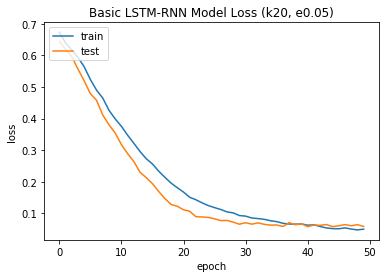

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k20, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

Test Accuracy is 0.981700016784668

############## Example 0 ##############
Expected:
 [0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1]
Actual:
 [0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1]

############## Example 1 ##############
Expected:
 [1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1]
Actual:
 [1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1]

############## Example 2 ##############
Expected:
 [0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0]
Actual:
 [0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0]

############## Example 3 ##############
Expected:
 [1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1]
Actual:
 [1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1]

############## Example 4 ##############
Expected:
 [1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0]
Actual:
 [1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0]


In [51]:
# model.save("../models/rnn_k20_e0.05.h5")
# experiment_results["k20_e0.05"] = {
#     "model": model,
#     "history": history
# }

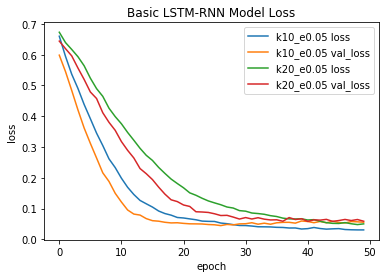

In [52]:
for name, exp in experiment_results.items():
    history = exp["history"]
    plt.plot(history.history['loss'], label="{0} loss".format(name))
    plt.plot(history.history['val_loss'], label="{0} val_loss".format(name))
    plt.xlabel('epoch')
    plt.ylabel('loss')

plt.title('Basic LSTM-RNN Model Loss')
plt.legend()
plt.show()

k:40, e:0.05

In [54]:
train, test, original = build_data_from_path("../data/dataset_n25000_k40_e0.05.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [57]:
lr = 0.001
model = Sequential()

model.add(Embedding(8, 10))
model.add(Dropout(0.5))

model.add(LSTM(400, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(400, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(80, activation="sigmoid"))
model.add(Reshape((40,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=50, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
 - 11s - loss: 0.6920 - acc: 0.5103 - val_loss: 0.6874 - val_acc: 0.5133
Epoch 2/50
 - 11s - loss: 0.6823 - acc: 0.5171 - val_loss: 0.6739 - val_acc: 0.5179
Epoch 3/50
 - 11s - loss: 0.6748 - acc: 0.5224 - val_loss: 0.6686 - val_acc: 0.5269
Epoch 4/50
 - 11s - loss: 0.6704 - acc: 0.5269 - val_loss: 0.6627 - val_acc: 0.5417
Epoch 5/50
 - 11s - loss: 0.6647 - acc: 0.5403 - val_loss: 0.6546 - val_acc: 0.5569
Epoch 6/50
 - 11s - loss: 0.6573 - acc: 0.5562 - val_loss: 0.6436 - val_acc: 0.5791
Epoch 7/50
 - 11s - loss: 0.6498 - acc: 0.5716 - val_loss: 0.6352 - val_acc: 0.5909
Epoch 8/50
 - 11s - loss: 0.6416 - acc: 0.5853 - val_loss: 0.6232 - val_acc: 0.6070
Epoch 9/50
 - 11s - loss: 0.6328 - acc: 0.5997 - val_loss: 0.6150 - val_acc: 0.6211
Epoch 10/50
 - 11s - loss: 0.6247 - acc: 0.6114 - val_loss: 0.6042 - val_acc: 0.6350
Epoch 11/50
 - 11s - loss: 0.6151 - acc: 0.6253 - val_loss: 0.5927 - val_acc: 0.6503
Epoch 12/50
 - 11s - loss

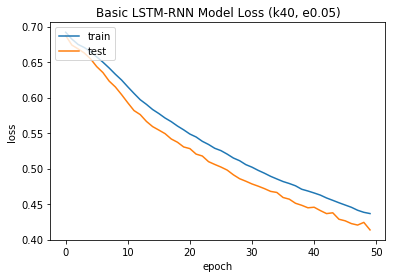

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k40, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's keep training with lower learning rate

In [61]:
lr = 0.0005
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
 - 11s - loss: 0.4310 - acc: 0.7751 - val_loss: 0.4083 - val_acc: 0.7913
Epoch 2/10
 - 11s - loss: 0.4266 - acc: 0.7775 - val_loss: 0.4054 - val_acc: 0.7933
Epoch 3/10
 - 11s - loss: 0.4250 - acc: 0.7786 - val_loss: 0.4033 - val_acc: 0.7945
Epoch 4/10
 - 11s - loss: 0.4225 - acc: 0.7794 - val_loss: 0.4021 - val_acc: 0.7955
Epoch 5/10
 - 11s - loss: 0.4210 - acc: 0.7808 - val_loss: 0.4015 - val_acc: 0.7960
Epoch 6/10
 - 11s - loss: 0.4192 - acc: 0.7820 - val_loss: 0.4020 - val_acc: 0.7973
Epoch 7/10
 - 11s - loss: 0.4173 - acc: 0.7826 - val_loss: 0.3973 - val_acc: 0.7989
Epoch 8/10
 - 11s - loss: 0.4154 - acc: 0.7843 - val_loss: 0.3971 - val_acc: 0.7993
Epoch 9/10
 - 11s - loss: 0.4135 - acc: 0.7849 - val_loss: 0.3954 - val_acc: 0.8005
Epoch 10/10
 - 11s - loss: 0.4127 - acc: 0.7861 - val_loss: 0.3927 - val_acc: 0.8014


In [62]:
lr = 0.005
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
 - 11s - loss: 0.5772 - acc: 0.6358 - val_loss: 0.4974 - val_acc: 0.7000
Epoch 2/10
 - 11s - loss: 0.5018 - acc: 0.7076 - val_loss: 0.4574 - val_acc: 0.7434
Epoch 3/10
 - 11s - loss: 0.4722 - acc: 0.7391 - val_loss: 0.4341 - val_acc: 0.7671
Epoch 4/10
 - 11s - loss: 0.4602 - acc: 0.7507 - val_loss: 0.4213 - val_acc: 0.7768
Epoch 5/10
 - 11s - loss: 0.4474 - acc: 0.7619 - val_loss: 0.4178 - val_acc: 0.7809
Epoch 6/10
 - 11s - loss: 0.4389 - acc: 0.7680 - val_loss: 0.3995 - val_acc: 0.7925
Epoch 7/10
 - 11s - loss: 0.4290 - acc: 0.7754 - val_loss: 0.3941 - val_acc: 0.7984
Epoch 8/10
 - 11s - loss: 0.4245 - acc: 0.7788 - val_loss: 0.3888 - val_acc: 0.8030
Epoch 9/10
 - 11s - loss: 0.4175 - acc: 0.7824 - val_loss: 0.3834 - val_acc: 0.8028
Epoch 10/10
 - 11s - loss: 0.4101 - acc: 0.7865 - val_loss: 0.3686 - val_acc: 0.8143


In [63]:
lr = 0.001
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
 - 12s - loss: 0.3867 - acc: 0.7996 - val_loss: 0.3451 - val_acc: 0.8270
Epoch 2/10
 - 11s - loss: 0.3751 - acc: 0.8065 - val_loss: 0.3416 - val_acc: 0.8305
Epoch 3/10
 - 11s - loss: 0.3703 - acc: 0.8092 - val_loss: 0.3399 - val_acc: 0.8304
Epoch 4/10
 - 11s - loss: 0.3661 - acc: 0.8116 - val_loss: 0.3376 - val_acc: 0.8325
Epoch 5/10
 - 11s - loss: 0.3621 - acc: 0.8140 - val_loss: 0.3332 - val_acc: 0.8352
Epoch 6/10
 - 11s - loss: 0.3612 - acc: 0.8150 - val_loss: 0.3337 - val_acc: 0.8349
Epoch 7/10
 - 11s - loss: 0.3587 - acc: 0.8159 - val_loss: 0.3298 - val_acc: 0.8390
Epoch 8/10
 - 11s - loss: 0.3547 - acc: 0.8188 - val_loss: 0.3325 - val_acc: 0.8384
Epoch 9/10
 - 11s - loss: 0.3524 - acc: 0.8199 - val_loss: 0.3250 - val_acc: 0.8419
Epoch 10/10
 - 11s - loss: 0.3490 - acc: 0.8220 - val_loss: 0.3235 - val_acc: 0.8448


In [68]:
lr = 0.0005
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 12s - loss: 0.3439 - acc: 0.8250 - val_loss: 0.3186 - val_acc: 0.8457
Epoch 2/20
 - 11s - loss: 0.3411 - acc: 0.8266 - val_loss: 0.3165 - val_acc: 0.8467
Epoch 3/20
 - 11s - loss: 0.3403 - acc: 0.8267 - val_loss: 0.3171 - val_acc: 0.8481
Epoch 4/20
 - 11s - loss: 0.3378 - acc: 0.8289 - val_loss: 0.3135 - val_acc: 0.8497
Epoch 5/20
 - 11s - loss: 0.3360 - acc: 0.8298 - val_loss: 0.3141 - val_acc: 0.8505
Epoch 6/20
 - 11s - loss: 0.3343 - acc: 0.8307 - val_loss: 0.3121 - val_acc: 0.8512
Epoch 7/20
 - 11s - loss: 0.3330 - acc: 0.8309 - val_loss: 0.3110 - val_acc: 0.8513
Epoch 8/20
 - 11s - loss: 0.3319 - acc: 0.8319 - val_loss: 0.3093 - val_acc: 0.8532
Epoch 9/20
 - 11s - loss: 0.3299 - acc: 0.8330 - val_loss: 0.3089 - val_acc: 0.8529
Epoch 10/20
 - 11s - loss: 0.3289 - acc: 0.8338 - val_loss: 0.3082 - val_acc: 0.8531
Epoch 11/20
 - 11s - loss: 0.3276 - acc: 0.8344 - val_loss: 0.3110 - val_acc: 0.8511
Epoch 12/20
 - 11s - loss

In [70]:
lr = 0.0005
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 12s - loss: 0.3164 - acc: 0.8405 - val_loss: 0.2962 - val_acc: 0.8622
Epoch 2/20
 - 11s - loss: 0.3133 - acc: 0.8421 - val_loss: 0.2947 - val_acc: 0.8623
Epoch 3/20
 - 11s - loss: 0.3116 - acc: 0.8431 - val_loss: 0.2954 - val_acc: 0.8640
Epoch 4/20
 - 11s - loss: 0.3117 - acc: 0.8437 - val_loss: 0.2944 - val_acc: 0.8642
Epoch 5/20
 - 11s - loss: 0.3100 - acc: 0.8439 - val_loss: 0.2927 - val_acc: 0.8652
Epoch 6/20
 - 11s - loss: 0.3095 - acc: 0.8452 - val_loss: 0.2927 - val_acc: 0.8658
Epoch 7/20
 - 11s - loss: 0.3085 - acc: 0.8458 - val_loss: 0.2894 - val_acc: 0.8664
Epoch 8/20
 - 11s - loss: 0.3069 - acc: 0.8463 - val_loss: 0.2905 - val_acc: 0.8665
Epoch 9/20
 - 11s - loss: 0.3058 - acc: 0.8470 - val_loss: 0.2883 - val_acc: 0.8662
Epoch 10/20
 - 11s - loss: 0.3050 - acc: 0.8473 - val_loss: 0.2866 - val_acc: 0.8681
Epoch 11/20
 - 11s - loss: 0.3040 - acc: 0.8477 - val_loss: 0.2865 - val_acc: 0.8691
Epoch 12/20
 - 11s - loss

In [74]:
lr = 0.001
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 12s - loss: 0.3099 - acc: 0.8462 - val_loss: 0.2798 - val_acc: 0.8738
Epoch 2/20
 - 11s - loss: 0.2950 - acc: 0.8534 - val_loss: 0.2845 - val_acc: 0.8703
Epoch 3/20
 - 11s - loss: 0.3038 - acc: 0.8497 - val_loss: 0.2738 - val_acc: 0.8752
Epoch 4/20
 - 11s - loss: 0.2939 - acc: 0.8548 - val_loss: 0.2744 - val_acc: 0.8761
Epoch 5/20
 - 11s - loss: 0.2931 - acc: 0.8549 - val_loss: 0.2731 - val_acc: 0.8770
Epoch 6/20
 - 11s - loss: 0.2914 - acc: 0.8560 - val_loss: 0.2715 - val_acc: 0.8789
Epoch 7/20
 - 11s - loss: 0.2878 - acc: 0.8575 - val_loss: 0.2704 - val_acc: 0.8791
Epoch 8/20
 - 11s - loss: 0.2873 - acc: 0.8579 - val_loss: 0.2690 - val_acc: 0.8802
Epoch 9/20
 - 11s - loss: 0.2845 - acc: 0.8590 - val_loss: 0.2671 - val_acc: 0.8816
Epoch 10/20
 - 11s - loss: 0.2843 - acc: 0.8598 - val_loss: 0.2635 - val_acc: 0.8822
Epoch 11/20
 - 11s - loss: 0.2834 - acc: 0.8604 - val_loss: 0.2651 - val_acc: 0.8818
Epoch 12/20
 - 11s - loss

In [76]:
lr = 0.002
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 12s - loss: 0.3744 - acc: 0.8171 - val_loss: 0.2865 - val_acc: 0.8696
Epoch 2/20
 - 11s - loss: 0.2965 - acc: 0.8548 - val_loss: 0.2576 - val_acc: 0.8868
Epoch 3/20
 - 11s - loss: 0.2888 - acc: 0.8597 - val_loss: 0.2639 - val_acc: 0.8838
Epoch 4/20
 - 11s - loss: 0.2857 - acc: 0.8614 - val_loss: 0.2526 - val_acc: 0.8912
Epoch 5/20
 - 11s - loss: 0.2817 - acc: 0.8631 - val_loss: 0.2524 - val_acc: 0.8875
Epoch 6/20
 - 11s - loss: 0.3027 - acc: 0.8526 - val_loss: 0.2563 - val_acc: 0.8843
Epoch 7/20
 - 11s - loss: 0.2923 - acc: 0.8583 - val_loss: 0.2442 - val_acc: 0.8916
Epoch 8/20
 - 11s - loss: 0.2768 - acc: 0.8657 - val_loss: 0.2403 - val_acc: 0.8965
Epoch 9/20
 - 11s - loss: 0.2702 - acc: 0.8695 - val_loss: 0.2411 - val_acc: 0.8956
Epoch 10/20
 - 11s - loss: 0.2672 - acc: 0.8707 - val_loss: 0.2363 - val_acc: 0.8988
Epoch 11/20
 - 11s - loss: 0.2656 - acc: 0.8718 - val_loss: 0.2375 - val_acc: 0.8989
Epoch 12/20
 - 11s - loss

In [79]:
lr = 0.001
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 12s - loss: 0.2635 - acc: 0.8737 - val_loss: 0.2140 - val_acc: 0.9089
Epoch 2/20
 - 11s - loss: 0.2507 - acc: 0.8806 - val_loss: 0.2127 - val_acc: 0.9106
Epoch 3/20
 - 11s - loss: 0.2489 - acc: 0.8813 - val_loss: 0.2118 - val_acc: 0.9119
Epoch 4/20
 - 11s - loss: 0.2473 - acc: 0.8826 - val_loss: 0.2133 - val_acc: 0.9118
Epoch 5/20
 - 11s - loss: 0.2467 - acc: 0.8829 - val_loss: 0.2099 - val_acc: 0.9137
Epoch 6/20
 - 11s - loss: 0.2422 - acc: 0.8850 - val_loss: 0.2078 - val_acc: 0.9139
Epoch 7/20
 - 11s - loss: 0.2415 - acc: 0.8852 - val_loss: 0.2034 - val_acc: 0.9151
Epoch 8/20
 - 11s - loss: 0.2387 - acc: 0.8872 - val_loss: 0.2055 - val_acc: 0.9164
Epoch 9/20
 - 11s - loss: 0.2375 - acc: 0.8875 - val_loss: 0.2053 - val_acc: 0.9165
Epoch 10/20
 - 11s - loss: 0.2380 - acc: 0.8874 - val_loss: 0.2043 - val_acc: 0.9165
Epoch 11/20
 - 11s - loss: 0.2346 - acc: 0.8890 - val_loss: 0.2001 - val_acc: 0.9179
Epoch 12/20
 - 11s - loss

In [83]:
history = {
    "loss": [0.692 , 0.6823, 0.6748, 0.6704, 0.6647, 0.6573, 0.6498, 0.6416,
       0.6328, 0.6247, 0.6151, 0.6059, 0.597 , 0.5905, 0.5832, 0.5775,
       0.5712, 0.5661, 0.5599, 0.5545, 0.5486, 0.5445, 0.5384, 0.534 ,
       0.5286, 0.5253, 0.5204, 0.5149, 0.5111, 0.5056, 0.502 , 0.4975,
       0.4935, 0.4891, 0.4854, 0.4818, 0.479 , 0.4758, 0.4709, 0.4684,
       0.4657, 0.4627, 0.4586, 0.4553, 0.4519, 0.4487, 0.4455, 0.4413,
       0.4384, 0.4367, 0.431 , 0.4266, 0.425 , 0.4225, 0.421 , 0.4192,
       0.4173, 0.4154, 0.4135, 0.4127, 0.4101, 0.3867, 0.3751, 0.3703,
       0.3661, 0.3621, 0.3612, 0.3587, 0.3547, 0.3524, 0.349 , 0.3439,
       0.3411, 0.3403, 0.3378, 0.336 , 0.3343, 0.333 , 0.3319, 0.3299,
       0.3289, 0.3276, 0.3262, 0.324 , 0.3234, 0.3219, 0.3195, 0.3192,
       0.3173, 0.3155, 0.3164, 0.3133, 0.3116, 0.3117, 0.31  , 0.3095,
       0.3085, 0.3069, 0.3058, 0.305 , 0.304 , 0.3034, 0.3015, 0.3007,
       0.3   , 0.2993, 0.2983, 0.2953, 0.2943, 0.2928, 0.2914, 0.2878,
       0.2873, 0.2845, 0.2843, 0.2834, 0.2829, 0.2831, 0.2814, 0.2801,
       0.2793, 0.2786, 0.2736, 0.2706, 0.2702, 0.2672, 0.2656, 0.2632,
       0.2602, 0.2885, 0.2765, 0.2694, 0.264 , 0.261 , 0.2635, 0.2507,
       0.2489, 0.2473, 0.2467, 0.2422, 0.2415, 0.2387, 0.2375, 0.238 ,
       0.2346, 0.2335, 0.2332, 0.2315, 0.2282, 0.2267, 0.2252, 0.2248,
       0.2236, 0.2229],
    "val_loss": [0.6874, 0.6739, 0.6686, 0.6627, 0.6546, 0.6436, 0.6352, 0.6232,
       0.615 , 0.6042, 0.5927, 0.5817, 0.5761, 0.5664, 0.5591, 0.5542,
       0.5492, 0.5417, 0.5371, 0.5305, 0.5281, 0.5204, 0.5177, 0.5098,
       0.5058, 0.5022, 0.4979, 0.4913, 0.4858, 0.4822, 0.4784, 0.4752,
       0.4718, 0.4679, 0.4664, 0.4593, 0.4569, 0.4512, 0.4483, 0.4448,
       0.4456, 0.4409, 0.4366, 0.4378, 0.4287, 0.4265, 0.4225, 0.4205,
       0.4242, 0.4136, 0.4083, 0.4054, 0.4033, 0.4021, 0.4015, 0.402 ,
       0.3973, 0.3971, 0.3954, 0.3927, 0.3686, 0.3451, 0.3416, 0.3399,
       0.3376, 0.3332, 0.3337, 0.3298, 0.3325, 0.325 , 0.3235, 0.3186,
       0.3165, 0.3171, 0.3135, 0.3141, 0.3121, 0.311 , 0.3093, 0.3089,
       0.3082, 0.311 , 0.3056, 0.3036, 0.3015, 0.3019, 0.3005, 0.3006,
       0.2982, 0.2971, 0.2962, 0.2947, 0.2954, 0.2944, 0.2927, 0.2927,
       0.2894, 0.2905, 0.2883, 0.2866, 0.2865, 0.2868, 0.2846, 0.2841,
       0.283 , 0.2828, 0.2807, 0.2787, 0.2796, 0.2764, 0.2715, 0.2704,
       0.269 , 0.2671, 0.2635, 0.2651, 0.2646, 0.261 , 0.2626, 0.2601,
       0.2666, 0.2563, 0.2542, 0.2541, 0.2411, 0.2363, 0.2375, 0.2321,
       0.2332, 0.2326, 0.2313, 0.2276, 0.2246, 0.2189, 0.214 , 0.2127,
       0.2118, 0.2133, 0.2099, 0.2078, 0.2034, 0.2055, 0.2053, 0.2043,
       0.2001, 0.1994, 0.1974, 0.1961, 0.1949, 0.1941, 0.1932, 0.1942,
       0.192 , 0.1918]
}

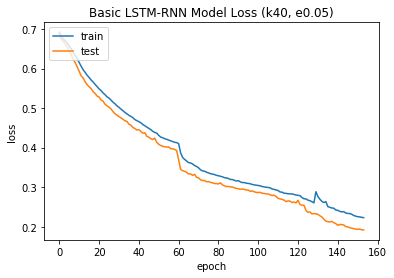

In [86]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k40, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

Test Accuracy is 0.9270724857330322

############## Example 0 ##############
Expected:
 [1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1
 1 0 0]
Actual:
 [1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1
 1 0 0]

############## Example 1 ##############
Expected:
 [1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1
 0 1 0]
Actual:
 [1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1
 0 1 0]

############## Example 2 ##############
Expected:
 [1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 0]
Actual:
 [1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 0]

############## Example 3 ##############
Expected:
 [1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1
 0 1 0]
Actual:
 [1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1
 0 1 0]

############## Example 4 ##############
Expected:
 [1 0

In [95]:
# model.save("../models/rnn_k40_e0.05.h5")
# experiment_results["k40_e0.05"] = {
#     "model": model,
#     "history": history
# }

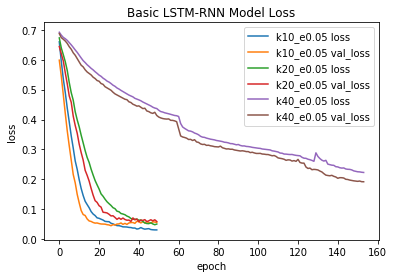

In [88]:
for name, exp in experiment_results.items():
    history = exp["history"]
    if type(history) != dict:
        history = history.history
    plt.plot(history['loss'], label="{0} loss".format(name))
    plt.plot(history['val_loss'], label="{0} val_loss".format(name))
    plt.xlabel('epoch')
    plt.ylabel('loss')

plt.title('Basic LSTM-RNN Model Loss')
plt.legend()
plt.show()

In [96]:
model = experiment_results["k40_e0.05"]["model"]
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))

Test Accuracy is 0.8889424924850464


In [97]:
model = experiment_results["k40_e0.05"]["model"]
lr = 0.005
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 12s - loss: 0.3809 - acc: 0.7892 - val_loss: 0.2780 - val_acc: 0.8491
Epoch 2/20
 - 11s - loss: 0.2916 - acc: 0.8354 - val_loss: 0.2469 - val_acc: 0.8671
Epoch 3/20
 - 11s - loss: 0.2668 - acc: 0.8509 - val_loss: 0.2300 - val_acc: 0.8777
Epoch 4/20
 - 11s - loss: 0.2584 - acc: 0.8569 - val_loss: 0.2220 - val_acc: 0.8822
Epoch 5/20
 - 11s - loss: 0.2543 - acc: 0.8597 - val_loss: 0.2195 - val_acc: 0.8858
Epoch 6/20
 - 11s - loss: 0.2481 - acc: 0.8631 - val_loss: 0.2165 - val_acc: 0.8874
Epoch 7/20
 - 11s - loss: 0.2478 - acc: 0.8642 - val_loss: 0.2110 - val_acc: 0.8868
Epoch 8/20
 - 11s - loss: 0.2459 - acc: 0.8654 - val_loss: 0.2109 - val_acc: 0.8899
Epoch 9/20
 - 11s - loss: 0.2421 - acc: 0.8673 - val_loss: 0.2096 - val_acc: 0.8910
Epoch 10/20
 - 11s - loss: 0.2395 - acc: 0.8697 - val_loss: 0.2053 - val_acc: 0.8966
Epoch 11/20
 - 11s - loss: 0.2355 - acc: 0.8714 - val_loss: 0.2077 - val_acc: 0.8917
Epoch 12/20
 - 11s - loss

In [98]:
lr = 0.005
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 13s - loss: 0.3339 - acc: 0.8193 - val_loss: 0.2031 - val_acc: 0.8937
Epoch 2/20
 - 11s - loss: 0.2304 - acc: 0.8767 - val_loss: 0.1885 - val_acc: 0.9038
Epoch 3/20
 - 11s - loss: 0.2136 - acc: 0.8855 - val_loss: 0.1803 - val_acc: 0.9095
Epoch 4/20
 - 11s - loss: 0.2091 - acc: 0.8880 - val_loss: 0.1757 - val_acc: 0.9095
Epoch 5/20
 - 11s - loss: 0.2106 - acc: 0.8876 - val_loss: 0.1989 - val_acc: 0.8943
Epoch 6/20
 - 11s - loss: 0.2637 - acc: 0.8581 - val_loss: 0.1974 - val_acc: 0.8961
Epoch 7/20
 - 11s - loss: 0.2336 - acc: 0.8762 - val_loss: 0.1860 - val_acc: 0.9037
Epoch 8/20
 - 11s - loss: 0.2172 - acc: 0.8850 - val_loss: 0.1797 - val_acc: 0.9069
Epoch 9/20
 - 11s - loss: 0.2105 - acc: 0.8886 - val_loss: 0.1731 - val_acc: 0.9100
Epoch 10/20
 - 11s - loss: 0.2052 - acc: 0.8915 - val_loss: 0.1688 - val_acc: 0.9142
Epoch 11/20
 - 11s - loss: 0.2028 - acc: 0.8929 - val_loss: 0.1713 - val_acc: 0.9152
Epoch 12/20
 - 11s - loss

In [99]:
# model.save("../models/rnn_k40_e0.05.h5")
# experiment_results["k40_e0.05"] = {
#     "model": model,
#     "history": history
# }

In [100]:
lr = 0.001
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 13s - loss: 0.1714 - acc: 0.9105 - val_loss: 0.1571 - val_acc: 0.9270
Epoch 2/20
 - 11s - loss: 0.1661 - acc: 0.9130 - val_loss: 0.1585 - val_acc: 0.9287
Epoch 3/20
 - 11s - loss: 0.1635 - acc: 0.9141 - val_loss: 0.1597 - val_acc: 0.9293
Epoch 4/20
 - 11s - loss: 0.1617 - acc: 0.9151 - val_loss: 0.1578 - val_acc: 0.9302
Epoch 5/20
 - 11s - loss: 0.1604 - acc: 0.9157 - val_loss: 0.1572 - val_acc: 0.9295
Epoch 6/20
 - 11s - loss: 0.1595 - acc: 0.9161 - val_loss: 0.1572 - val_acc: 0.9293
Epoch 7/20
 - 11s - loss: 0.1588 - acc: 0.9170 - val_loss: 0.1555 - val_acc: 0.9310
Epoch 8/20
 - 11s - loss: 0.1607 - acc: 0.9165 - val_loss: 0.1588 - val_acc: 0.9314
Epoch 9/20
 - 11s - loss: 0.1572 - acc: 0.9179 - val_loss: 0.1573 - val_acc: 0.9313
Epoch 10/20
 - 11s - loss: 0.1567 - acc: 0.9187 - val_loss: 0.1571 - val_acc: 0.9319
Epoch 11/20
 - 11s - loss: 0.1546 - acc: 0.9195 - val_loss: 0.1559 - val_acc: 0.9320
Epoch 12/20
 - 11s - loss

In [105]:
lr = 0.005
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 14s - loss: 0.2345 - acc: 0.8844 - val_loss: 0.1613 - val_acc: 0.9288
Epoch 2/20
 - 11s - loss: 0.1741 - acc: 0.9124 - val_loss: 0.1552 - val_acc: 0.9343
Epoch 3/20
 - 11s - loss: 0.1660 - acc: 0.9155 - val_loss: 0.1566 - val_acc: 0.9337
Epoch 4/20
 - 11s - loss: 0.1677 - acc: 0.9153 - val_loss: 0.1528 - val_acc: 0.9349
Epoch 5/20
 - 11s - loss: 0.1719 - acc: 0.9138 - val_loss: 0.1518 - val_acc: 0.9354
Epoch 6/20
 - 11s - loss: 0.1679 - acc: 0.9152 - val_loss: 0.1497 - val_acc: 0.9352
Epoch 7/20
 - 11s - loss: 0.1656 - acc: 0.9160 - val_loss: 0.1523 - val_acc: 0.9356
Epoch 8/20
 - 11s - loss: 0.1625 - acc: 0.9175 - val_loss: 0.1492 - val_acc: 0.9347
Epoch 9/20
 - 11s - loss: 0.1658 - acc: 0.9160 - val_loss: 0.1517 - val_acc: 0.9337
Epoch 10/20
 - 11s - loss: 0.1653 - acc: 0.9166 - val_loss: 0.1448 - val_acc: 0.9346
Epoch 11/20
 - 11s - loss: 0.1647 - acc: 0.9176 - val_loss: 0.1510 - val_acc: 0.9346
Epoch 12/20
 - 11s - loss

In [111]:
history = {
    "loss": [0.692 , 0.6823, 0.6748, 0.6704, 0.6647, 0.6573, 0.6498, 0.6416,
       0.6328, 0.6247, 0.6151, 0.6059, 0.597 , 0.5905, 0.5832, 0.5775,
       0.5712, 0.5661, 0.5599, 0.5545, 0.5486, 0.5445, 0.5384, 0.534 ,
       0.5286, 0.5253, 0.5204, 0.5149, 0.5111, 0.5056, 0.502 , 0.4975,
       0.4935, 0.4891, 0.4854, 0.4818, 0.479 , 0.4758, 0.4709, 0.4684,
       0.4657, 0.4627, 0.4586, 0.4553, 0.4519, 0.4487, 0.4455, 0.4413,
       0.4384, 0.4367, 0.431 , 0.4266, 0.425 , 0.4225, 0.421 , 0.4192,
       0.4173, 0.4154, 0.4135, 0.4127, 0.4101, 0.3809, 0.2916, 0.2668,
       0.2584, 0.2543, 0.2481, 0.2478, 0.2459, 0.2421, 0.2395, 0.2355,
       0.2344, 0.2325, 0.2306, 0.2297, 0.2278, 0.2237, 0.221 , 0.2196,
       0.2182, 0.2136, 0.2091, 0.2106, 0.2637, 0.2336, 0.2172, 0.2105, 
       0.2052, 0.2028, 0.1977, 0.1961, 0.1926, 0.192 , 0.1907, 0.1885, 
       0.1868, 0.1878, 0.1853, 0.1714, 0.1661, 0.1635, 0.1617, 0.1604, 
       0.1595, 0.1588, 0.1607, 0.1572, 0.1567, 0.1546, 0.1547, 0.154 , 
       0.1536, 0.1528, 0.1517, 0.1514, 0.1496, 0.1499, 0.1505],
    "val_loss": [0.6874, 0.6739, 0.6686, 0.6627, 0.6546, 0.6436, 0.6352, 0.6232,
       0.615 , 0.6042, 0.5927, 0.5817, 0.5761, 0.5664, 0.5591, 0.5542,
       0.5492, 0.5417, 0.5371, 0.5305, 0.5281, 0.5204, 0.5177, 0.5098,
       0.5058, 0.5022, 0.4979, 0.4913, 0.4858, 0.4822, 0.4784, 0.4752,
       0.4718, 0.4679, 0.4664, 0.4593, 0.4569, 0.4512, 0.4483, 0.4448,
       0.4456, 0.4409, 0.4366, 0.4378, 0.4287, 0.4265, 0.4225, 0.4205,
       0.4242, 0.4136, 0.4083, 0.4054, 0.4033, 0.4021, 0.4015, 0.402 ,
       0.3973, 0.3971, 0.3954, 0.3927, 0.3686, 0.278 , 0.2469, 0.23  ,
       0.222 , 0.2195, 0.2165, 0.211 , 0.2109, 0.2096, 0.2053, 0.2077,
       0.2037, 0.1969, 0.1971, 0.1917, 0.1985, 0.1911, 0.1884, 0.1865,
       0.1851, 0.1803, 0.1757, 0.1989, 0.1974, 0.186 , 0.1797, 0.1731,
       0.1688, 0.1713, 0.1682, 0.1667, 0.1675, 0.1655, 0.1604, 0.1618,
       0.1641, 0.1631, 0.1603, 0.1571, 0.1585, 0.1597, 0.1578, 0.1572,
       0.1572, 0.1555, 0.1588, 0.1573, 0.1571, 0.1559, 0.1575, 0.1631,
       0.1556, 0.1581, 0.156 , 0.1567, 0.1611, 0.1577, 0.1551]
}

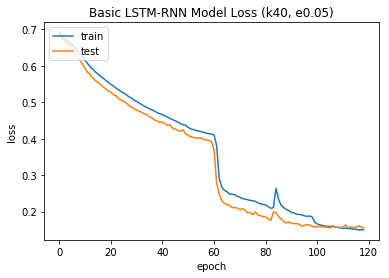

In [112]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k40, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

Test Accuracy is 0.9357274904251098

############## Example 0 ##############
Expected:
 [1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1
 1 0 1]
Actual:
 [0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1
 1 0 1]

############## Example 1 ##############
Expected:
 [0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0
 1 1 0]
Actual:
 [0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0
 1 1 0]

############## Example 2 ##############
Expected:
 [0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1
 0 0 1]
Actual:
 [0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1
 0 0 1]

############## Example 3 ##############
Expected:
 [1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1
 0 1 1]
Actual:
 [0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1
 0 1 1]

############## Example 4 ##############
Expected:
 [0 0

In [113]:
# model.save("../models/rnn_k40_e0.05.h5")
# experiment_results["k40_e0.05"] = {
#     "model": model,
#     "history": history
# }

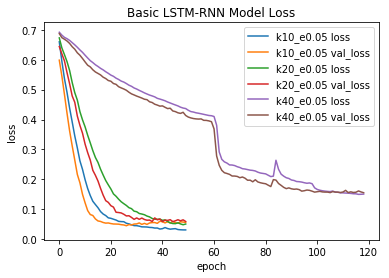

In [115]:
for name, exp in experiment_results.items():
    history = exp["history"]
    if type(history) != dict:
        history = history.history
    plt.plot(history['loss'], label="{0} loss".format(name))
    plt.plot(history['val_loss'], label="{0} val_loss".format(name))
    plt.xlabel('epoch')
    plt.ylabel('loss')

plt.title('Basic LSTM-RNN Model Loss')
plt.legend()
plt.show()

k10, e0.15

In [121]:
train, test, original = build_data_from_path("../data/dataset_n25000_k10_e0.15.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [134]:
lr = 0.01
model = Sequential()

model.add(Embedding(2, 10))
model.add(Dropout(0.5))

model.add(LSTM(200, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=50, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
 - 6s - loss: 0.6551 - acc: 0.5526 - val_loss: 0.6105 - val_acc: 0.5947
Epoch 2/50
 - 3s - loss: 0.6049 - acc: 0.5988 - val_loss: 0.5741 - val_acc: 0.6161
Epoch 3/50
 - 3s - loss: 0.5868 - acc: 0.6139 - val_loss: 0.5615 - val_acc: 0.6272
Epoch 4/50
 - 3s - loss: 0.5742 - acc: 0.6256 - val_loss: 0.5491 - val_acc: 0.6406
Epoch 5/50
 - 3s - loss: 0.5627 - acc: 0.6363 - val_loss: 0.5371 - val_acc: 0.6564
Epoch 6/50
 - 3s - loss: 0.5494 - acc: 0.6504 - val_loss: 0.5251 - val_acc: 0.6682
Epoch 7/50
 - 3s - loss: 0.5424 - acc: 0.6591 - val_loss: 0.5150 - val_acc: 0.6751
Epoch 8/50
 - 3s - loss: 0.5303 - acc: 0.6676 - val_loss: 0.5184 - val_acc: 0.6721
Epoch 9/50
 - 3s - loss: 0.5249 - acc: 0.6736 - val_loss: 0.4963 - val_acc: 0.6952
Epoch 10/50
 - 3s - loss: 0.5118 - acc: 0.6871 - val_loss: 0.4869 - val_acc: 0.7049
Epoch 11/50
 - 3s - loss: 0.5055 - acc: 0.6940 - val_loss: 0.4837 - val_acc: 0.7184
Epoch 12/50
 - 3s - loss: 0.4918 - a

In [135]:
experiment_results2 = dict()

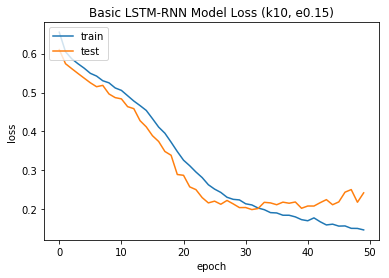

In [136]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k10, e0.15)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [137]:
# model.save("../models/rnn_k10_e0.15.h5")
# experiment_results2["k10_e0.15"] = {
#     "model": model,
#     "history": history
# }

In [138]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

Test Accuracy is 0.9241900190353394

############## Example 0 ##############
Expected:
 [0 1 0 1 1 1 1 1 0 0]
Actual:
 [0 1 0 1 1 1 1 1 0 0]

############## Example 1 ##############
Expected:
 [0 0 0 0 1 1 1 1 0 0]
Actual:
 [0 0 1 0 1 1 1 1 0 0]

############## Example 2 ##############
Expected:
 [0 1 1 0 1 1 0 1 0 0]
Actual:
 [0 1 1 0 1 1 0 1 0 0]

############## Example 3 ##############
Expected:
 [0 0 1 1 1 1 0 0 0 0]
Actual:
 [0 0 0 1 1 1 0 0 0 0]

############## Example 4 ##############
Expected:
 [1 0 1 0 0 1 0 0 0 0]
Actual:
 [1 0 1 0 0 1 0 0 0 0]


k20 e0.15

In [147]:
train, test, original = build_data_from_path("../data/dataset_n25000_k20_e0.15.pkl")
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [148]:
lr = 0.01
model = Sequential()

model.add(Embedding(4, 10))
model.add(Dropout(0.5))

model.add(LSTM(400, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(400, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(40, activation="sigmoid"))
model.add(Reshape((20,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=50, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
 - 12s - loss: 0.6730 - acc: 0.5271 - val_loss: 0.6492 - val_acc: 0.5484
Epoch 2/50
 - 8s - loss: 0.6467 - acc: 0.5526 - val_loss: 0.6364 - val_acc: 0.5597
Epoch 3/50
 - 8s - loss: 0.6393 - acc: 0.5583 - val_loss: 0.6314 - val_acc: 0.5639
Epoch 4/50
 - 8s - loss: 0.6358 - acc: 0.5618 - val_loss: 0.6300 - val_acc: 0.5619
Epoch 5/50
 - 8s - loss: 0.6318 - acc: 0.5668 - val_loss: 0.6195 - val_acc: 0.5750
Epoch 6/50
 - 8s - loss: 0.6257 - acc: 0.5730 - val_loss: 0.6100 - val_acc: 0.5820
Epoch 7/50
 - 8s - loss: 0.6214 - acc: 0.5770 - val_loss: 0.6111 - val_acc: 0.5791
Epoch 8/50
 - 8s - loss: 0.6166 - acc: 0.5819 - val_loss: 0.6046 - val_acc: 0.5879
Epoch 9/50
 - 8s - loss: 0.6113 - acc: 0.5874 - val_loss: 0.5951 - val_acc: 0.5969
Epoch 10/50
 - 8s - loss: 0.6048 - acc: 0.5939 - val_loss: 0.5898 - val_acc: 0.6034
Epoch 11/50
 - 8s - loss: 0.5988 - acc: 0.5997 - val_loss: 0.5892 - val_acc: 0.6062
Epoch 12/50
 - 8s - loss: 0.5950 - 

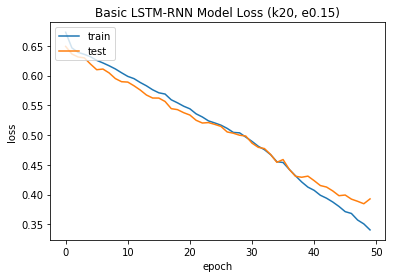

In [149]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k20, e0.15)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [152]:
opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history2 = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 12s - loss: 0.3373 - acc: 0.8336 - val_loss: 0.3760 - val_acc: 0.8363
Epoch 2/20
 - 8s - loss: 0.3139 - acc: 0.8464 - val_loss: 0.3689 - val_acc: 0.8371
Epoch 3/20
 - 8s - loss: 0.3053 - acc: 0.8516 - val_loss: 0.3663 - val_acc: 0.8424
Epoch 4/20
 - 8s - loss: 0.3054 - acc: 0.8522 - val_loss: 0.3807 - val_acc: 0.8421
Epoch 5/20
 - 8s - loss: 0.2946 - acc: 0.8586 - val_loss: 0.3667 - val_acc: 0.8464
Epoch 6/20
 - 8s - loss: 0.2935 - acc: 0.8598 - val_loss: 0.3749 - val_acc: 0.8451
Epoch 7/20
 - 8s - loss: 0.2831 - acc: 0.8656 - val_loss: 0.3627 - val_acc: 0.8478
Epoch 8/20
 - 8s - loss: 0.2798 - acc: 0.8675 - val_loss: 0.3599 - val_acc: 0.8545
Epoch 9/20
 - 8s - loss: 0.2730 - acc: 0.8723 - val_loss: 0.3540 - val_acc: 0.8536
Epoch 10/20
 - 8s - loss: 0.2660 - acc: 0.8757 - val_loss: 0.3747 - val_acc: 0.8527
Epoch 11/20
 - 8s - loss: 0.2683 - acc: 0.8760 - val_loss: 0.3544 - val_acc: 0.8587
Epoch 12/20
 - 8s - loss: 0.2576 - 

In [154]:
history3 = {
    "loss": history.history["loss"] + history2.history["loss"],
    "val_loss": history.history["val_loss"] + history2.history["val_loss"]
}

In [156]:
# model.save("../models/rnn_k20_e0.15.h5")
# experiment_results2["k20_e0.15"] = {
#     "model": model,
#     "history": history3
# }

In [160]:
history4 = model.fit(X_train, y_train, epochs=15, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/15
 - 9s - loss: 0.1556 - acc: 0.9352 - val_loss: 0.4552 - val_acc: 0.8848
Epoch 2/15
 - 8s - loss: 0.1507 - acc: 0.9382 - val_loss: 0.4273 - val_acc: 0.8863
Epoch 3/15
 - 8s - loss: 0.1510 - acc: 0.9383 - val_loss: 0.4348 - val_acc: 0.8862
Epoch 4/15
 - 8s - loss: 0.1498 - acc: 0.9390 - val_loss: 0.4587 - val_acc: 0.8869
Epoch 5/15
 - 8s - loss: 0.1483 - acc: 0.9401 - val_loss: 0.4565 - val_acc: 0.8866
Epoch 6/15
 - 8s - loss: 0.1566 - acc: 0.9358 - val_loss: 0.3938 - val_acc: 0.8859
Epoch 7/15
 - 8s - loss: 0.1606 - acc: 0.9346 - val_loss: 0.4327 - val_acc: 0.8870
Epoch 8/15
 - 8s - loss: 0.1445 - acc: 0.9413 - val_loss: 0.4305 - val_acc: 0.8868
Epoch 9/15
 - 8s - loss: 0.1397 - acc: 0.9437 - val_loss: 0.4093 - val_acc: 0.8879
Epoch 10/15
 - 8s - loss: 0.1396 - acc: 0.9437 - val_loss: 0.4360 - val_acc: 0.8889
Epoch 11/15
 - 8s - loss: 0.1337 - acc: 0.9460 - val_loss: 0.4692 - val_acc: 0.8889
Epoch 12/15
 - 8s - loss: 0.1336 - a

In [163]:
history5 = {
    "loss": history3["loss"] + history4.history["loss"],
    "val_loss": history3["val_loss"] + history4.history["val_loss"]
}

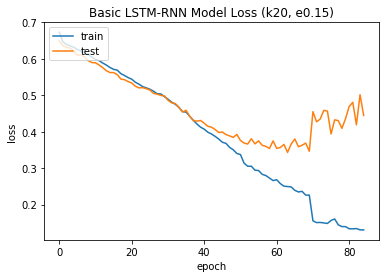

In [164]:
plt.plot(history5['loss'])
plt.plot(history5['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k20, e0.15)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [171]:
# model.save("../models/rnn_k20_e0.15.h5")
# experiment_results2["k20_e0.15"] = {
#     "model": model,
#     "history": history5
# }

In [170]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))
pred_vs_truth(model, X_test, y_test, n_show=5, y_truth_is_onehot=True)

Test Accuracy is 0.8867800210952759

############## Example 0 ##############
Expected:
 [1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1]
Actual:
 [1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0]

############## Example 1 ##############
Expected:
 [0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0]
Actual:
 [0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0]

############## Example 2 ##############
Expected:
 [0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1]
Actual:
 [0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1]

############## Example 3 ##############
Expected:
 [1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0]
Actual:
 [1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0]

############## Example 4 ##############
Expected:
 [0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1]
Actual:
 [1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1]


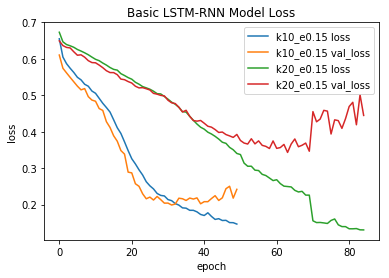

In [172]:
for name, exp in experiment_results2.items():
    history = exp["history"]
    if type(history) != dict:
        history = history.history
    plt.plot(history['loss'], label="{0} loss".format(name))
    plt.plot(history['val_loss'], label="{0} val_loss".format(name))
    plt.xlabel('epoch')
    plt.ylabel('loss')

plt.title('Basic LSTM-RNN Model Loss')
plt.legend()
plt.show()

k10-90 e0.05

In [ ]:
experiment_results3 = dict()

In [ ]:
for k in np.hstack([np.arange(5,51,5),np.arange(55,100,10)]):
    print("Training k = {0} ...".format(k))
    
    if "k{0}".format(k) in experiment_results3:
        print("--- Done! Test Accuracy for k = {0} is {1}".format(k, \
                experiment_results3["k{0}".format(k)]["test_acc"]))
        continue
    
    train, test, original = build_data_from_path("../data/dataset_n25000_k{0}_e0.05.pkl".format(k))
    X_train, y_train = train
    X_test, y_test = test
    X, y, y_oh, y_viterbi_decoded = original

    lr = 0.01
    model = Sequential()

    model.add(Embedding(k * 2 // 10, 10))
    model.add(Dropout(0.5))

    model.add(LSTM(min(k * 20, 600), activation="tanh", input_shape=X_train.shape[1:]))
    model.add(Dropout(0.5))

    model.add(Dense(min(k * 20, 1000), activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(k * 2, activation="sigmoid"))
    model.add(Reshape((k, 2)))

    opt = optimizers["adam"](lr=lr)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    
    history = model.fit(X_train, y_train, epochs=30, batch_size=1024, verbose=0,
              shuffle=True, validation_split=0.2)

    test_acc = model_accuracy(model, X_test, y_test, argmax=False)
    
    experiment_results3["k{0}".format(k)] = {
        "model": model,
        "history": history,
        "test_acc": test_acc
    }
    print("--- Done! Test Accuracy for k = {0} is {1}".format(k, test_acc))

Training k = 5 ...


In [ ]:
for name, exp in experiment_results3.items():
    history = exp["history"]
    if type(history) != dict:
        history = history.history
    plt.plot(history['loss'], label="{0} loss".format(name))
    
    exp["model"].save("models/epoch30_lr0.005/{0}.h5".format(name))

plt.title('Basic LSTM-RNN Model Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
for name, exp in experiment_results3.items():
    history = exp["history"]
    if type(history) != dict:
        history = history.history
    plt.plot(history['val_loss'], label="{0} val_loss".format(name))
    
    exp["model"].save("models/epoch30_lr0.005/{0}.h5".format(name))

plt.title('Basic LSTM-RNN Model Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
test_accuracies = [x["test_acc"] for k, x in experiment_results3.items()]
ks = np.hstack([np.arange(5,51,5),np.arange(55,100,10)])

plt.title('Basic LSTM-RNN Model Test Accuracy')
plt.plot(test_accuracies, 'go-', label="Test Accuracy")
plt.xlabel('Messge Length k')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()